In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import random

# Using CIFAR-10

In [15]:
transform_train = transforms.Compose([
    transforms.Resize(224),  # ResNet input size
    transforms.ToTensor()
])
transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor()
])

# Load full training dataset
full_train_dataset = datasets.CIFAR10(root='./data/', train=True, download=True, transform=transform_train)
full_test_dataset = datasets.CIFAR10(root='./data/', train=False, download=True, transform=transform_train)

# Create a subset with 10% of the training data
subset_size = int(0.1 * len(full_train_dataset))
indices = random.sample(range(len(full_train_dataset)), subset_size)
train_subset = Subset(full_train_dataset, indices)

train_loader = DataLoader(
    train_subset,
    batch_size=64, shuffle=True
)

# Create a subset with 20% of the test data
subset_size = int(0.2 * len(full_test_dataset))
indices = random.sample(range(len(full_test_dataset)), subset_size)
test_subset = Subset(full_test_dataset, indices)

test_loader = DataLoader(
    test_subset,
    batch_size=256, shuffle=False
)

In [16]:
len(test_loader.dataset), len(train_loader.dataset)

(2000, 5000)

# Teacher Model - Resnet 18

In [10]:
# Teacher: ResNet18
teacher = models.resnet18(pretrained=True)

num_ftrs = teacher.fc.in_features
teacher.fc = torch.nn.Linear(num_ftrs, 10)  # For CIFAR-10

optimizer_t = optim.Adam(teacher.parameters(), lr=0.001)
for epoch in range(1):  # 1 epoch just to have a semi-trained teacher
    teacher.train()
    for imgs, labels in train_loader:
        optimizer_t.zero_grad()
        loss = F.cross_entropy(teacher(imgs), labels)
        loss.backward()
        optimizer_t.step()

# Teacher accuracy
def accuracy(model):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, labels in test_loader:
            preds = model(imgs).argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total

print("Teacher accuracy:", accuracy(teacher))

/Users/adan.mora/Desktop/code/university/deep-learning-and-big-data-course/venv/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/adan.mora/Desktop/code/university/deep-learning-and-big-data-course/venv/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Teacher accuracy: 0.6941


In [ ]:
# Save Teacher state
torch.save(teacher.state_dict(), f"./data/resnet18_teacher_state_one_epoch.pth")

# Shared in Drive folder: https://drive.google.com/drive/folders/1ZbYJft8q1wVr74rCDuIUuBA_oB-QUBvo?usp=drive_link

In [ ]:
# Load Teacher state

model = models.resnet18(pretrained=True)

num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)

model.load_state_dict(torch.load("./data/resnet18_teacher_state_one_epoch.pth", weights_only=True, map_location=torch.device('cpu')))
model.eval()

# Tiny Student model

In [25]:
# class TinyCNN(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
#         self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
#         self.fc1 = nn.Linear(32 * 56 * 56, 64)
#         self.fc2 = nn.Linear(64, 10)

#     def forward(self, x):
#         x = F.relu(self.conv1(x))
#         x = F.max_pool2d(x, 2)
#         x = F.relu(self.conv2(x))
#         x = F.max_pool2d(x, 2)
#         x = torch.flatten(x, 1)
#         x = F.relu(self.fc1(x))
#         return self.fc2(x)
    
class TinyCNN(nn.Module):
    def __init__(self):
        super(TinyCNN, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.fc_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(200704, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.conv_layer(x)
        x = self.fc_layer(x)
        return x

# Distillation Loss

In [26]:
def distillation_loss(student_logits, teacher_logits, labels, T, alpha):
    hard_loss = F.cross_entropy(student_logits, labels)
    soft_loss = F.kl_div(
        F.log_softmax(student_logits / T, dim=1),
        F.softmax(teacher_logits / T, dim=1),
        reduction='batchmean'
    ) * (T * T)                 # We multiply the KL loss by T^2 to keep gradient magnitudes balanced after scaling.
    return alpha * soft_loss + (1 - alpha) * hard_loss

# Training Student using the Distillation process

In [27]:
student = TinyCNN()
optimizer_s = optim.Adam(student.parameters(), lr=0.001)
T = 4.0
alpha = 0.7

student_acc_list = []
teacher_acc_list = []
kl_distance_list = []

for epoch in range(5):
    student.train()
    for imgs, labels in train_loader:
        with torch.no_grad():
            teacher_logits = teacher(imgs)

        student_logits = student(imgs)
        loss = distillation_loss(student_logits, teacher_logits, labels, T, alpha)

        optimizer_s.zero_grad()
        loss.backward()
        optimizer_s.step()

    # Track metrics
    student_acc = accuracy(student)
    teacher_acc = accuracy(teacher)
    student_acc_list.append(student_acc)
    teacher_acc_list.append(teacher_acc)

    # KL divergence measure
    kl_total = 0
    with torch.no_grad():
        for imgs, _ in test_loader:
            st_logits = student(imgs)
            tc_logits = teacher(imgs)
            kl_total += F.kl_div(
                F.log_softmax(st_logits / T, dim=1),
                F.softmax(tc_logits / T, dim=1),
                reduction='batchmean'
            ).item()
    kl_distance_list.append(kl_total / len(test_loader))

    print(f"Epoch {epoch+1}: Student Acc={student_acc:.3f}, KL Dist={kl_distance_list[-1]:.4f}")

Epoch 1: Student Acc=0.261, KL Dist=0.2096
Epoch 2: Student Acc=0.339, KL Dist=0.1853
Epoch 3: Student Acc=0.363, KL Dist=0.1803
Epoch 4: Student Acc=0.365, KL Dist=0.1694
Epoch 5: Student Acc=0.390, KL Dist=0.1679


# Evaluation results

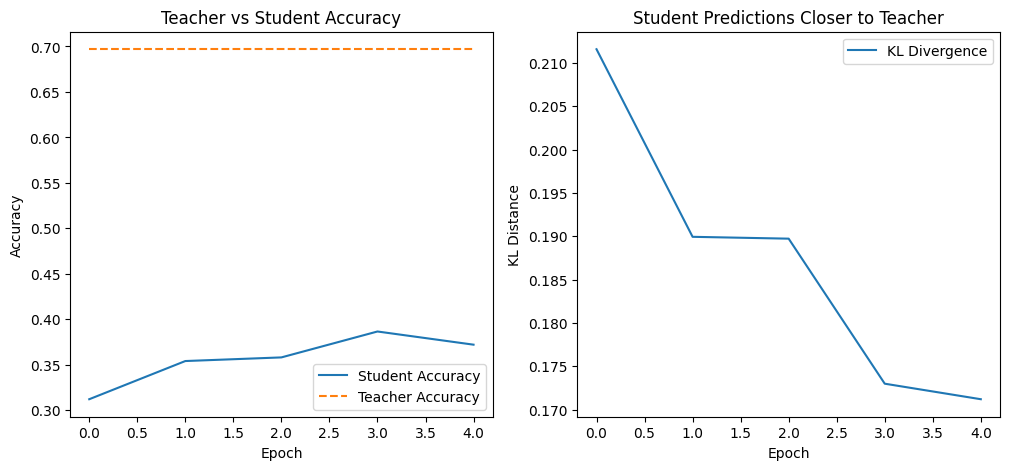

In [20]:


# ----- 6. Plot -----
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(student_acc_list, label='Student Accuracy')
plt.plot(teacher_acc_list, label='Teacher Accuracy', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Teacher vs Student Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(kl_distance_list, label='KL Divergence')
plt.xlabel('Epoch')
plt.ylabel('KL Distance')
plt.title('Student Predictions Closer to Teacher')
plt.legend()

plt.show()
